# Which authors tends to be more collaborative with external institutions?

In this script we will try to answer the question of which authors tends to be more collaborative with EUTOPIA institutions. 

## Brief overview

We see that the number of external collaborations almost coincides with the number of publications. We observe the collaboration rate, which is the proportion of external collaborations to the total number of publications.

we calculate the mean and median collaboration rates for authors with EUTOPIA institutions. The threshold for top collaborators is set as the median collaboration rate plus one standard deviation. We identify the top collaborators as those with collaboration rates higher than this threshold.

At the time of writing, the threshold is: **95.77%**.

We see that the collaboration


The mean collaboration rate is 0.22, while the median collaboration rate is 0.73. The standard deviation of the collaboration rate is 0.73. We also identify the top collaborators as those with collaboration rates higher than the median plus one standard deviation.
We also calculate the percentile of each author's collaboration rate based on the distribution of collaboration rates.
This percentile represents the author's relative position compared to other authors in terms of collaboration rates.

Results are saved to BigQuery table `FCT_AUTHOR_COLLABORATIVENESS`.



## Global imports & settings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from box import Box
from google.cloud import bigquery
from scipy.stats import percentileofscore

In [5]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../src/config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
schema = config.GCP.READ_SCHEMA
# Set the BigQuery write dataset schema
write_schema = config.GCP.ANALYTICS_SCHEMA
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

# Target table name
TARGET_TABLE_NAME = 'FCT_AUTHOR_COLLABORATIVENESS'

## Data preparation
After loading the general configuration, we will prepare the data from BigQuery:
1. Count the number of publications and external collaborations for each author. 
2. Calculate the proportion of external collaborations for each author.
3. Filter out authors from non-EUTOPIA institutions and authors with zero publications or zero collaborations.
4. Clip the collaboration rate to avoid zero or one values and filter out outliers with extremely low numbers of publications.

In [12]:
# Read data via BigQuery
query = f"""
SELECT
  AUTHOR_SID,
  COUNT(ARTICLE_SID)                                                AS PUBLICATIONS,
  COUNT(DISTINCT IF(IS_EXTERNAL_COLLABORATION, ARTICLE_SID, NULL))  AS EXTERNAL_COLLABORATIONS
FROM
    {schema}.FCT_COLLABORATION
-- WHERE IS_ARTICLE_RELEVANT
GROUP BY AUTHOR_SID
"""
df_init = client.query(query).to_dataframe()

In [13]:

# Initialize data frame for transformation
df_transformed = df_init.copy()

# We need to calculate the proportion of external collaborations for each author
df_transformed['COLLABORATION_RATE'] = df_transformed['EXTERNAL_COLLABORATIONS'] / df_transformed['PUBLICATIONS']


# Handle zero publications or zero collaborations
df_transformed = df_transformed[(df_transformed['PUBLICATIONS'] > 0) & (df_transformed['EXTERNAL_COLLABORATIONS'] >= 0)]
# Filter out outliers with extremely low number of publications
df_transformed = df_transformed[(df_transformed['PUBLICATIONS'] >= 10)]
# Clip the collaboration rate to avoid zero or one values (outliers)
df_transformed['COLLABORATION_RATE'] = np.clip(a=df_transformed['COLLABORATION_RATE'],
                                   a_min=1e-6,
                                   a_max=1 - 1e-6)

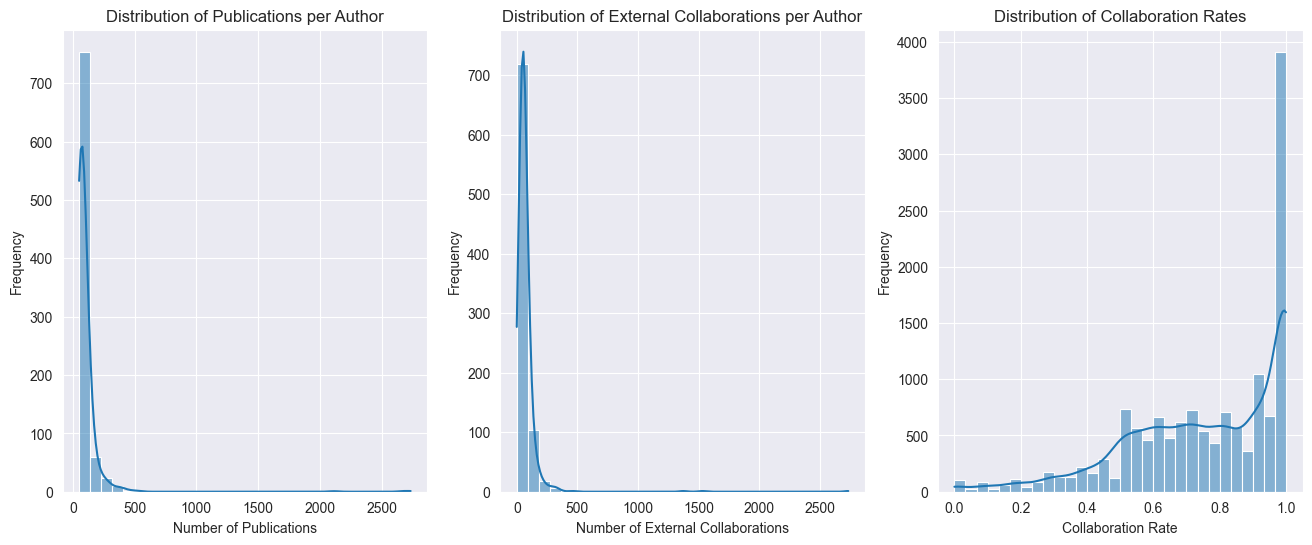

In [14]:
# Visualize the distributions of publications and external collaborations in side-by-side histograms
# 1. Distribution of Publications per Author
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(16, 6))
sns.histplot(df_transformed[df_transformed['PUBLICATIONS'] > 50]['PUBLICATIONS'], bins=30, kde=True, ax=plt1)
plt1.set_title('Distribution of Publications per Author')
plt1.set_xlabel('Number of Publications')
plt1.set_ylabel('Frequency')
# 2. Distribution of External Collaborations per Author
sns.histplot(df_transformed[df_transformed['PUBLICATIONS'] > 50]['EXTERNAL_COLLABORATIONS'], bins=30, kde=True, ax=plt2)
plt2.set_title('Distribution of External Collaborations per Author')
plt2.set_xlabel('Number of External Collaborations')
plt2.set_ylabel('Frequency')

# 3. Distribution of Collaboration Rates
sns.histplot(df_transformed['COLLABORATION_RATE'], bins=30, kde=True, ax=plt3)
plt3.set_title('Distribution of Collaboration Rates')
plt3.set_xlabel('Collaboration Rate')
plt3.set_ylabel('Frequency')
plt.show()

## Descritive statistics

We will calculate some base descriptive statistics for the collaboration rate of authors with EUTOPIA institutions. Using mean and median values, we can get a sense of the central tendency of the collaboration rates. The standard deviation provides information about the variability of the collaboration rates. Due to the skewed distribution of publications and external collaborations, we use the median as a more robust measure of central tendency and standard deviation as a measure of variability.

In [15]:
# Calculate descriptive statistics
mean_collab_rate = df_transformed['COLLABORATION_RATE'].mean()
median_collab_rate = df_transformed['COLLABORATION_RATE'].median()
std_collab_rate = df_transformed['COLLABORATION_RATE'].std()
# Outputs
print(f'Mean Collaboration Rate: {mean_collab_rate:.2f}')
print(f'Median Collaboration Rate: {median_collab_rate:.2f}')
print(f'Standard Deviation of Collaboration Rate: {std_collab_rate:.2f}')

# Identify top collaborators (those with collaboration rates above median + std)
threshold = median_collab_rate + std_collab_rate
top_collaborators = df_transformed[df_transformed['COLLABORATION_RATE'] > threshold]
# Outputs
print(f'Threshold for top collaborators: {threshold:.2f}')
print(f'Number of top collaborators: {len(top_collaborators)}')

Mean Collaboration Rate: 0.76
Median Collaboration Rate: 0.80
Standard Deviation of Collaboration Rate: 0.23
Threshold for top collaborators: 1.03
Number of top collaborators: 0


## Analysis: author collaborativeness with external institutions

The expected value of the collaboration rate
, which represents the central tendency of the collaboration rates across all authors. We compare individual authors' collaboration rates to the inferred mean collaboration rate. Authors with collaboration rates higher than this mean are considered to be more collaborative with external institutions. 

Lastly, we calculate the percentile of each author's collaboration rate. This percentile represents the author's relative position compared to other authors in terms of collaboration rates. 

### Analyze percentiles of collaboration rates



In [16]:
# Calculate the collaboration rate percentiles for each author
collaboration_rate_samples = df_transformed['COLLABORATION_RATE'].values
collaboration_rate_samples_sorted = np.sort(collaboration_rate_samples)
percentiles = np.array([percentileofscore(collaboration_rate_samples_sorted, x) for x in df_transformed['COLLABORATION_RATE']])
df_transformed['COLLABORATION_RATE_PERCENTILE'] = percentiles

# Get more collaborative authors
df_transformed['IS_AUTHOR_HIGH_COLLABORATOR'] = df_transformed['COLLABORATION_RATE'] > threshold

Query author full names from the dimension to facilitate further analysis. This initially served to understand which authors are more collaborative with external institutions and use our topic knowledge to identify them and validate the results.

In [17]:
# Query the author full names from DIM_AUTHOR table from BigQuery
query = f"""
SELECT
    A.AUTHOR_SID,
    A.AUTHOR_FULL_NAME,
    STRING_AGG(DISTINCT F.INSTITUTION_SID) AS INSTITUTIONS
FROM
    {schema}.FCT_COLLABORATION F
INNER JOIN 
    {schema}.DIM_AUTHOR A USING(AUTHOR_SID)
WHERE F.IS_ARTICLE_RELEVANT
GROUP BY A.AUTHOR_SID, A.AUTHOR_FULL_NAME
"""
# Query the author full names
df_transformed_author = client.query(query).to_dataframe()

Merge the top authors with their full names to facilitate further analysis. We will filter out authors working on institutions other than UNI_LJ and sort the authors by their collaboration rate percentiles in descending order. This will help us identify the most collaborative authors with external institutions. Since the author of this notebook was studying at UNI_LJ, we can validate the results based on the topic knowledge.

In [18]:
# Merge the top authors with their full names
authors = df_transformed.merge(df_transformed_author, on='AUTHOR_SID')
pd.set_option('display.max_rows', None)
# Only show authors working on institution UNI_LJ
authors[authors['INSTITUTIONS'].str.contains('UNI_LJ')].sort_values(by='COLLABORATION_RATE_PERCENTILE',
                                                                    ascending=False).head(100)

,AUTHOR_SID,PUBLICATIONS,EXTERNAL_COLLABORATIONS,COLLABORATION_RATE,COLLABORATION_RATE_PERCENTILE,IS_AUTHOR_HIGH_COLLABORATOR,AUTHOR_FULL_NAME,INSTITUTIONS
5065,d19cc63344aafaa5d6a0fdc2868654df,45,45,0.999999,86.880824,False,Mirjana Liovic,UNI_LJ
5131,abdbeb4d8dbe30df8430a8394b7218ef,20,20,0.999999,86.880824,False,Cene FiŠer,UNI_LJ
11413,6bb5117ad5c8d395ec5094cdbd1d4d0c,31,31,0.999999,86.880824,False,Mitja Peruš,UNI_LJ
6794,26608ab3541c6ee154edf7e77b82ba0f,26,26,0.999999,86.880824,False,Klemen Čotar,UNI_LJ
11833,fcb1c4d84b7a6b185108dc25de78f85e,10,10,0.999999,86.880824,False,Peter Prislan,"OTHER,UNI_LJ"
11698,5a1506c4d95f79e16e47d6cf16e3b304,11,11,0.999999,86.880824,False,Gregor Mali,"OTHER,UNI_LJ"
9932,2640310499e0ec4974bf5b67530d62fb,14,14,0.999999,86.880824,False,Stanislav Vrtnik,"OTHER,UNI_LJ"
12007,c1ca604ab3556bbade0f88c41977c288,12,12,0.999999,86.880824,False,Andraž Čarni,"OTHER,UNI_LJ"
3997,10199dc9210f687eb7a78388e51e843f,12,12,0.999999,86.880824,False,Matija Jezeršek,UNI_LJ
4144,99c00a27ce8bd9246b0efb549cf2c4dc,11,11,0.999999,86.880824,False,Tine Sattler,UNI_LJ


### Save the results to BigQuery table: FCT_AUTHOR_COLLABORATIVENESS

In [ ]:
df_transformed.head(5)

In [19]:
# Save the results to BigQuery
table_id = f"{write_schema}.{TARGET_TABLE_NAME}"
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(df_transformed, table_id, job_config=job_config)